Sajad Rahmanian
97101683

In [10]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

In [11]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform = Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y),
                                                                                    value=1))
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform = Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y),
                                                                                    value=1))
)

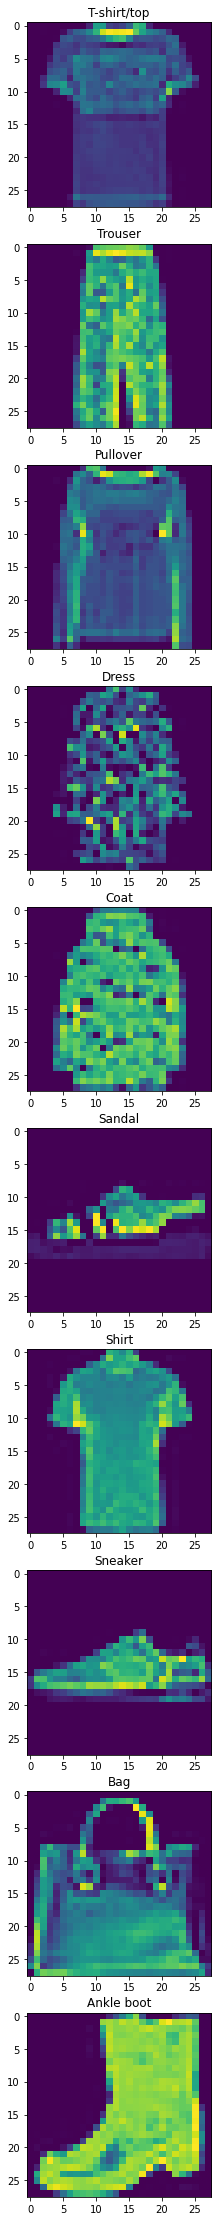

In [12]:
labels = training_data.classes

fig, ax = plt.subplots(nrows=10, ncols=1, figsize=(10, 40))

for i in range(len(labels)):
    idx = np.argwhere(training_data.targets == i).numpy()[0]
    idx = np.random.choice(idx, 1)[0]
    ax[i].imshow(training_data.data[idx].numpy())
    ax[i].set_title(labels[i])


In [13]:
input_size = training_data.data[0].shape[0] * training_data.data[0].shape[1]
output_size = len(training_data.classes)

In [14]:
class MyNet():
    def __init__(self, input_size, output_size):
        self.input_size = input_size
        self.output_size = output_size
        n_out1 = 32
        n_out2 = 32
        self.w1 = 0.01 * torch.randn((self.input_size, n_out1), requires_grad=True)
        self.b1 = 0.01 * torch.randn((1, n_out1), requires_grad=True)
        self.w2 = 0.01 * torch.randn((n_out1, n_out2), requires_grad=True)
        self.b2= 0.01 * torch.randn((1, n_out2), requires_grad=True)
        self.w3 = 0.01 * torch.randn((n_out2, self.output_size), requires_grad=True)
        self.b3 = 0.01 * torch.randn((1, self.output_size), requires_grad=True)
        self.W = [self.w1, self.w2, self.w3]
        self.b = [self.b1, self.b2, self.b3]

        relu = lambda x: x * (x > 0)
        self.activation_1 = relu
        self.activation_2 = relu
        self.softmax = lambda x: torch.exp(x) / torch.exp(x).sum(axis=1).reshape((-1, 1)).repeat(1, self.output_size)
        self.activation = [self.activation_1, self.activation_2, self.softmax]

    def model(self, xb):
        out = xb.clone()
        for i in range(len(self.W)):
            out = out @ self.W[i] + self.b[i]
            out = self.activation[i](out)
        yb = out
        return yb
    
    def loss(self, y_pred, y_true):
        # Cross Entropy
        logits = torch.log(y_pred)
        cross_entropy = -torch.sum(logits * y_true) / y_true.shape[0]
        return cross_entropy 
    
    def predict(self, x):
        probs = self.model(x)
        y_pred = probs.argmax(axis=1)
        return y_pred, probs
    
    def eval(self, X, y_one_hot):
        y_pred, probs = self.predict(X)
        loss_ = self.loss(probs, y_one_hot).detach().item()
        y_true = y_one_hot.argmax(axis=1)
        acc_ = torch.sum(y_pred == y_true) / X.shape[0]
        acc_ = acc_.item()
        return acc_, loss_ 

    def train(self, train_data, test_data, n_epochs, batch_size, lr=1e-3):

        X_train = train_data.data.view((-1, self.input_size)).float()
        X_test = test_data.data.view((-1, self.input_size)).float()
        y_train_one_hot = [train_data.target_transform(train_data.targets[i]).reshape((1, -1)) for i in range(len(train_data))]
        y_train_one_hot = torch.concat(y_train_one_hot, axis=0)
        y_test_one_hot = [test_data.target_transform(test_data.targets[i]).reshape((1, -1)) for i in range(len(test_data))]
        y_test_one_hot = torch.concat(y_test_one_hot, axis=0)

        n_batchs = int(X_train.shape[0] / batch_size)
        training_acc = []
        test_acc = []
        training_loss = []
        test_loss = []
        for epoch in range(n_epochs):
            start_idx = 0
            for _ in range(n_batchs):
                y_batch = torch.zeros((batch_size, self.output_size),  dtype=float)
                X_batch = X_train[start_idx:start_idx+batch_size, :]
                y_batch = y_train_one_hot[start_idx:start_idx+batch_size, :]   
                probs = self.model(X_batch)
                loss = self.loss(probs, y_batch)
                for i in range(len(self.W)):
                    self.W[i].retain_grad()
                    self.b[i].retain_grad()
                loss.backward(retain_graph=True)
                for i in range(len(self.W)):
                    self.W[i] = self.W[i] - lr * self.W[i].grad
                    self.b[i] = self.b[i] - lr * self.b[i].grad
                start_idx += batch_size

            acc_epoch_train, loss_epoch_train = self.eval(X_train, y_train_one_hot)
            acc_epoch_test, loss_epoch_test = self.eval(X_test, y_test_one_hot)
            training_acc.append(acc_epoch_train)
            test_acc.append(acc_epoch_test)
            training_loss.append(loss_epoch_train)
            test_loss.append(loss_epoch_test)

            print(f"Epoch #{epoch}: training_accuracy={round(acc_epoch_train*100, 2)}%, test_accuracy={round(acc_epoch_test*100, 2)}%\n, training_loss={round(loss_epoch_train, 2)}, test_loss={round(loss_epoch_test, 2)}")
        return training_acc, test_acc, training_loss, test_loss

In [15]:
n_epochs = 12
batch_size = 32
net = MyNet(input_size=28*28, output_size=10)
training_acc, test_acc, training_loss, test_loss = net.train(training_data, test_data, n_epochs, batch_size)

C:\Users\Sajjad\AppData\Local\Temp\ipykernel_11052\3414669425.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_transform = Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y),
C:\Users\Sajjad\AppData\Local\Temp\ipykernel_11052\3414669425.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_transform = Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y),


Epoch #0: training_accuracy=79.19%, test_accuracy=77.62%
, training_loss=0.6, test_loss=0.64
Epoch #1: training_accuracy=83.54%, test_accuracy=82.48%
, training_loss=0.47, test_loss=0.51
Epoch #2: training_accuracy=85.17%, test_accuracy=84.0%
, training_loss=0.42, test_loss=0.46
Epoch #3: training_accuracy=86.27%, test_accuracy=84.73%
, training_loss=0.39, test_loss=0.43
Epoch #4: training_accuracy=87.11%, test_accuracy=85.42%
, training_loss=0.36, test_loss=0.41
Epoch #5: training_accuracy=87.58%, test_accuracy=85.82%
, training_loss=0.35, test_loss=0.4
Epoch #6: training_accuracy=88.16%, test_accuracy=86.21%
, training_loss=0.33, test_loss=0.38
Epoch #7: training_accuracy=88.5%, test_accuracy=86.21%
, training_loss=0.32, test_loss=0.38
Epoch #8: training_accuracy=88.57%, test_accuracy=86.41%
, training_loss=0.31, test_loss=0.37
Epoch #9: training_accuracy=88.71%, test_accuracy=86.47%
, training_loss=0.31, test_loss=0.37
Epoch #10: training_accuracy=88.87%, test_accuracy=86.62%
, trai

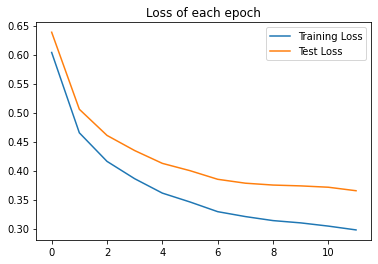

In [16]:
plt.figure()
plt.plot(np.arange(n_epochs), training_loss, label="Training Loss")
plt.plot(np.arange(n_epochs), test_loss, label="Test Loss")
plt.legend()
plt.title("Loss of each epoch")
plt.show()

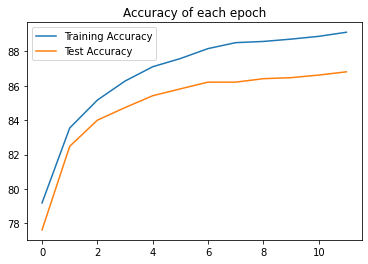

In [17]:
plt.figure()
plt.plot(np.arange(n_epochs), np.array(training_acc) * 100, label="Training Accuracy")
plt.plot(np.arange(n_epochs), np.array(test_acc) * 100, label="Test Accuracy")
plt.legend()
plt.title("Accuracy of each epoch")
plt.show()

In [18]:
random_samples = np.random.choice(np.arange(len(test_data)), 9, replace=False)

samples = test_data.data[random_samples].view((-1, input_size))
true_labels = test_data.targets[random_samples]
pred_labels, _ = net.predict(samples.float())


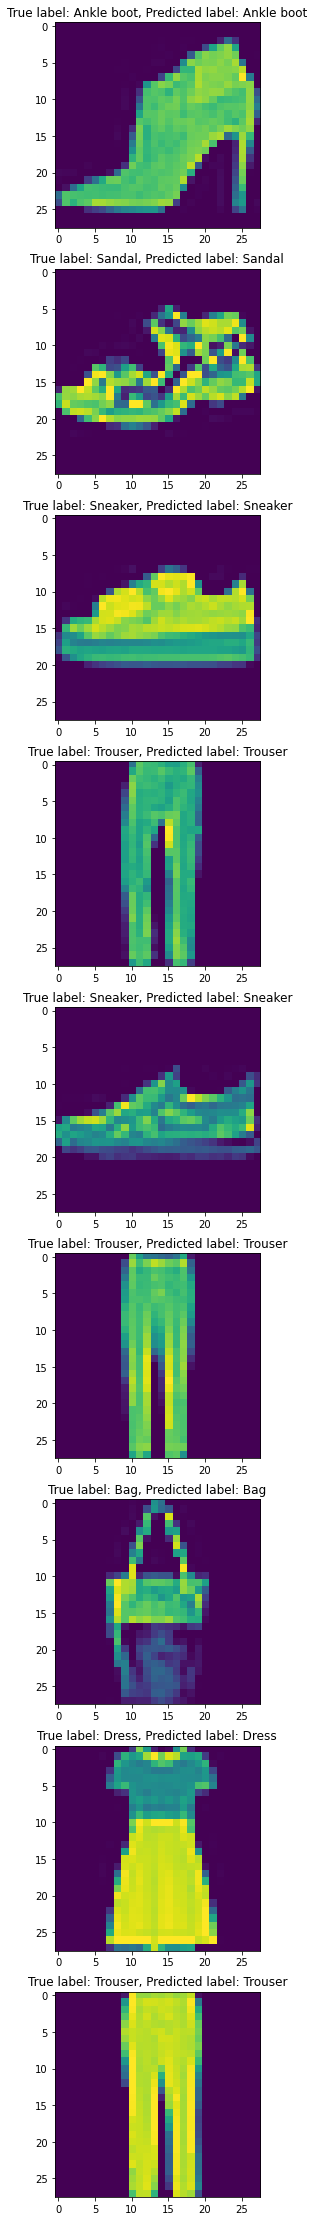

In [19]:
fig, ax = plt.subplots(nrows=9, ncols=1, figsize=(10, 40))

for i in range(len(random_samples)):
    ax[i].imshow(samples[i].view(training_data.data[0].shape).numpy())
    ax[i].set_title(f"True label: {test_data.classes[true_labels[i]]}, Predicted label: {test_data.classes[pred_labels[i]]}")